<a href="https://colab.research.google.com/github/Jaew00/AI-practice/blob/main/New_Nickel_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [5]:
raw_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Nickel_Final_DB1.csv')

In [6]:
raw_df

,Date,Price,Y2_Price,Y10_Price,UC_Price,EU_Price,GB_Price,JP_Price,NetWeight,TradeValue,WTI_Price,B_Price,Gas_Price,heating_Price,NAV,Dollor_Price,Stock,STS_price,Current_Price,CRB_Price
0,2011.1.4,25120.0,0.6210,3.338,6.6070,0.7514,0.6415,82.06,779926682,155396452.0,89.38,93.53,4.669,2.5065,31.64,79.440,136890.0,100.700,25175.0,327.76
1,2011.1.5,24720.0,0.7080,3.463,6.6193,0.7603,0.6448,83.19,779926682,155396452.0,90.30,95.50,4.473,2.5422,31.91,80.260,136860.0,100.700,24650.0,329.23
2,2011.1.6,24534.0,0.6770,3.399,6.6263,0.7686,0.6464,83.31,779926682,155396452.0,88.38,94.52,4.434,2.5112,31.57,80.790,137040.0,100.700,24875.0,325.10
3,2011.1.7,24180.0,0.5970,3.328,6.6282,0.7746,0.6428,83.14,779926682,155396452.0,88.03,93.33,4.422,2.4863,31.65,81.010,136896.0,100.700,24345.0,323.98
4,2011.1.10,23847.0,0.5730,3.287,6.6369,0.7723,0.6421,82.72,779926682,155396452.0,89.25,95.70,4.399,2.5561,31.88,80.880,136806.0,100.700,24050.0,326.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2778,2022.5.23,27732.0,2.6287,2.861,6.6490,0.9352,1.2588,127.87,49104116,16801717.0,109.77,110.78,8.796,3.7818,22.44,102.097,71922.0,177.145,26800.0,335.74
2779,2022.5.24,26550.0,2.4807,2.754,6.6530,0.9314,1.2529,126.80,49104116,16801717.0,110.33,110.69,8.971,3.8664,22.17,101.870,72120.0,177.145,26280.0,334.21
2780,2022.5.25,26788.0,2.5020,2.751,6.6916,0.9360,1.2564,127.31,49104116,16801717.0,114.09,111.12,8.908,3.9680,22.06,102.077,72600.0,177.145,26725.0,335.09
2781,2022.5.26,27198.0,2.4778,2.742,6.7380,0.9321,1.2594,127.14,49104116,16801717.0,115.07,114.17,8.727,4.0029,22.28,101.858,72300.0,177.145,27550.0,339.46


'Y2_Price','UC_Price',
       'GB_Price', 'WTI_Price',
       'heating_Price', 'NAV', 'Dollor_Price', 'CRB_Price'

In [7]:
df = raw_df[['Date', 'Y2_Price', 'heating_Price', 'WTI_Price', 'NAV',
       'Dollor_Price', 'GB_Price', 'UC_Price', 'CRB_Price', 'Price']]

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2783 entries, 2011-01-04 to 2022-05-27
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Y2_Price       2783 non-null   float64
 1   heating_Price  2783 non-null   float64
 2   WTI_Price      2783 non-null   float64
 3   NAV            2783 non-null   float64
 4   Dollor_Price   2783 non-null   float64
 5   GB_Price       2783 non-null   float64
 6   UC_Price       2783 non-null   float64
 7   CRB_Price      2783 non-null   float64
 8   Price          2783 non-null   float64
dtypes: float64(9)
memory usage: 217.4 KB


In [63]:
new_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/real_time_nickel.csv')

In [64]:
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df['Price'] = pd.to_numeric(new_df['Price']).astype(float)

new_df.set_index('Date', inplace = True)

In [65]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16 entries, 2022-07-19 to 2022-08-03
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   B_Price       16 non-null     float64
 1   WTI_Price     16 non-null     float64
 2   Price         16 non-null     float64
 3   Dollor_Price  16 non-null     float64
 4   EU_Price      16 non-null     float64
 5   JP_Price      16 non-null     float64
dtypes: float64(6)
memory usage: 896.0 bytes


In [13]:
x_cols = list(df.columns)
x_cols.remove("Price")

test_data_size = 700
X = df[x_cols]
Y = df['Price']


scaler = MinMaxScaler()

Xscaler = scaler.fit(X)
Yscaler = scaler.fit(Y.values.reshape(-1,1))

Y = Y.values.reshape(-1, 1)

X_train = scaler.fit_transform(X[:-test_data_size])
X_test = scaler.transform(X[-test_data_size:])
y_train = scaler.fit_transform(Y[:-test_data_size]).flatten()
y_test = scaler.transform(Y[-test_data_size:]).flatten()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2083, 8)
(700, 8)
(2083,)
(700,)


In [14]:
def create_sequences(array, seq_length) :
  res = []
  if seq_length == 1:
    for i in range(len(array)) :
      tmp = array[i:(i+seq_length)]
      res.append(tmp)

  else :
    for i in range(len(array) - seq_length-1) :
      tmp = array[i:(i+seq_length)]
      res.append(tmp)

  return res

In [15]:
seq_length = 1

X_train = create_sequences(X_train, seq_length)
X_test = create_sequences(X_test, seq_length)
y_train = create_sequences(y_train, seq_length)
y_test = create_sequences(y_test, seq_length)

In [16]:
X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """Entry point for launching an IPython kernel.


In [17]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([2083, 1, 8]) torch.Size([700, 1, 8])
torch.Size([2083, 1]) torch.Size([700, 1])


# Building a Model

LSTM

In [18]:
class LSTM(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(LSTM, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden, device=device),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden, device=device)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

CNN-LSTM

# Training

In [39]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() 
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    train_hist = []
    val_hist = []

    for t in range(num_epochs):

        epoch_loss = 0
        for idx, seq in enumerate(train_data): 
            model.reset_hidden_state() # seq 별 hidden state reset
            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss
            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            epoch_loss += loss.item()

            np.append(train_hist, (epoch_loss / len(train_data)))

        if val_data is not None:
            with torch.no_grad():
                val_loss = 0
                for val_idx, val_seq in enumerate(val_data):
                    model.reset_hidden_state() # seq 별로 hidden state 초기화 
                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])
                    val_loss += val_step_loss

                    np.append(val_hist, (val_loss / len(val_data)).cpu()) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            '''## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')
                    break'''

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

# LSTM

In [50]:
model = LSTM(
    n_features=X_train.shape[-1],
    n_hidden=1, 
    seq_len=seq_length,
    n_layers=2 #2가 베스트
).to(device)
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.21559440061643154 val loss: 0.2397046536207199
Epoch 10 train loss: 0.035580138670056126 val loss: 0.223918154835701
Epoch 20 train loss: 0.03340371632148197 val loss: 0.2378866821527481
Epoch 30 train loss: 0.03173464659710544 val loss: 0.23517867922782898
Epoch 40 train loss: 0.030965728169299066 val loss: 0.23870152235031128
Epoch 50 train loss: 0.029484209324225633 val loss: 0.23715455830097198
Epoch 60 train loss: 0.029188079732652188 val loss: 0.23257474601268768
Epoch 70 train loss: 0.02873782968605532 val loss: 0.23758657276630402
Epoch 80 train loss: 0.028574477908019542 val loss: 0.2377316653728485
Epoch 90 train loss: 0.028096762475518726 val loss: 0.23329022526741028


In [51]:
train_hist

[]

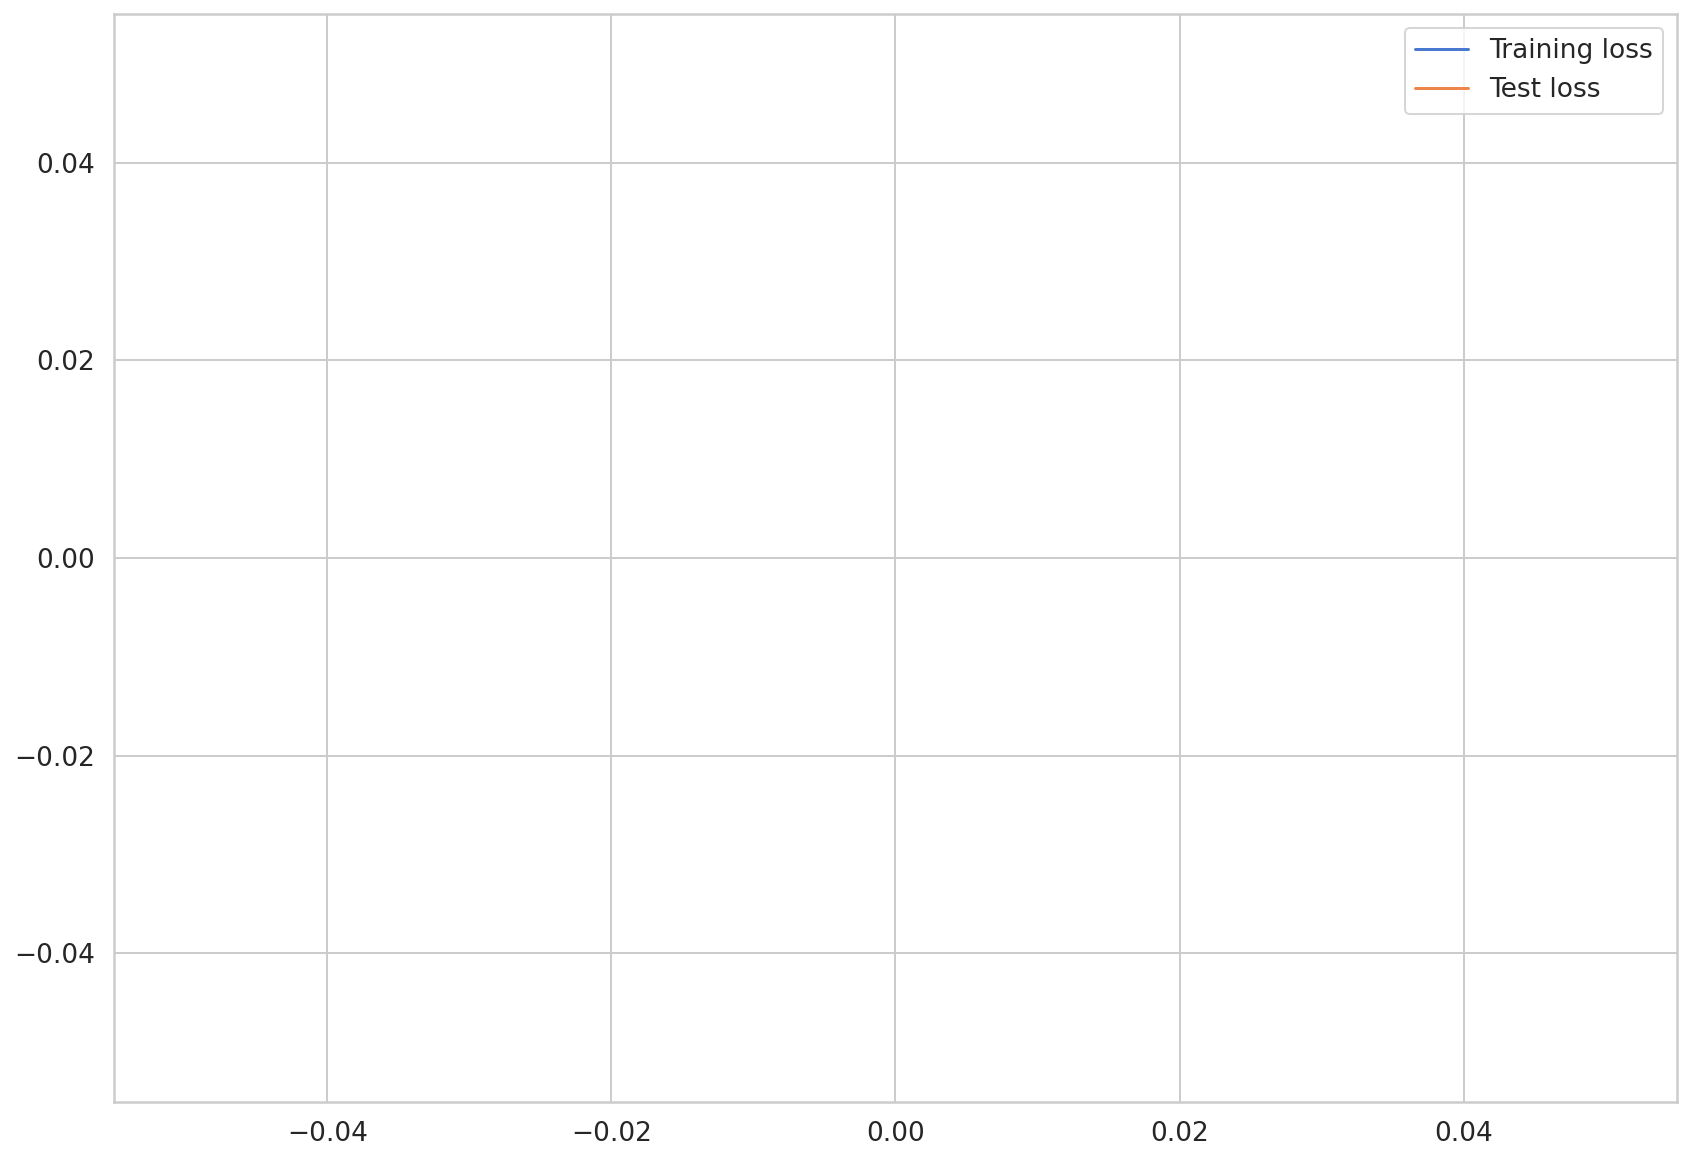

In [52]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Test loss")
#plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

In [53]:
with torch.no_grad():
  preds = []
  for i in range(len(X_test)):
    test_seq = X_test[i:i+1]
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.cpu().numpy().flatten()
    new_seq = np.append(new_seq, pred)
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(X_train.shape[-1], seq_length, 1).float()

In [54]:
preds


[0.3418717086315155,
 0.36864715814590454,
 0.3813035488128662,
 0.38547778129577637,
 0.3838695287704468,
 0.37972399592399597,
 0.3711010217666626,
 0.3642675280570984,
 0.35696715116500854,
 0.35331180691719055,
 0.3546411395072937,
 0.35620447993278503,
 0.35915660858154297,
 0.3612935543060303,
 0.3611328899860382,
 0.3584141433238983,
 0.3561994433403015,
 0.3539064824581146,
 0.35259971022605896,
 0.34624457359313965,
 0.3413219451904297,
 0.3333703875541687,
 0.33076074719429016,
 0.33095020055770874,
 0.3306325376033783,
 0.3316616117954254,
 0.33179402351379395,
 0.3279241919517517,
 0.3285212516784668,
 0.3273434340953827,
 0.32510611414909363,
 0.32214751839637756,
 0.32132622599601746,
 0.3138182759284973,
 0.3162245452404022,
 0.3138887882232666,
 0.3110729157924652,
 0.3078729212284088,
 0.30724334716796875,
 0.30724695324897766,
 0.305563747882843,
 0.3050200045108795,
 0.3059913218021393,
 0.308573454618454,
 0.3068120777606964,
 0.3057994544506073,
 0.3056534230709076

In [55]:
# Prediction value 스케일링 역변환
pred_values = Yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [56]:
pred_values

array([[14953.23286051],
       [15529.92249215],
       [15802.51583433],
       [15892.42045355],
       [15857.78191066],
       [15768.49542421],
       [15582.77380681],
       [15435.59401929],
       [15278.35850179],
       [15199.62969738],
       [15228.26086271],
       [15261.93208879],
       [15325.51503563],
       [15371.54057264],
       [15368.08018452],
       [15309.52381891],
       [15261.82361066],
       [15212.43781918],
       [15184.29255885],
       [15047.41562605],
       [14941.39205551],
       [14770.13140714],
       [14713.92497307],
       [14718.00541961],
       [14711.1635949 ],
       [14733.32779485],
       [14736.17967844],
       [14652.83124626],
       [14665.69071865],
       [14640.32288355],
       [14592.13548654],
       [14528.41325122],
       [14510.7242555 ],
       [14349.01802695],
       [14400.84425539],
       [14350.53672075],
       [14289.88846034],
       [14220.96697742],
       [14207.4072113 ],
       [14207.48487908],


In [57]:
pred_values_ceiled  = list(pred_values.flatten())

# True value 스케일링 역변환
true_values = Yscaler.inverse_transform(np.array(y_test.cpu()).reshape(-1,1))
# 실제값 예측값 데이터 프레임 생성

score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

score_table

,True,Pred
0,14137.999023,14953.232861
1,14345.000000,15529.922492
2,14307.999023,15802.515834
3,14553.000000,15892.420454
4,14473.000000,15857.781911
...,...,...
695,27731.998047,17397.361927
696,26550.000000,17395.203277
697,26788.000000,17393.158881
698,27197.998047,17391.651100


In [58]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 29569974.419775773, RMSE : 5437.828097666915, SCORE : 91.62493756110493


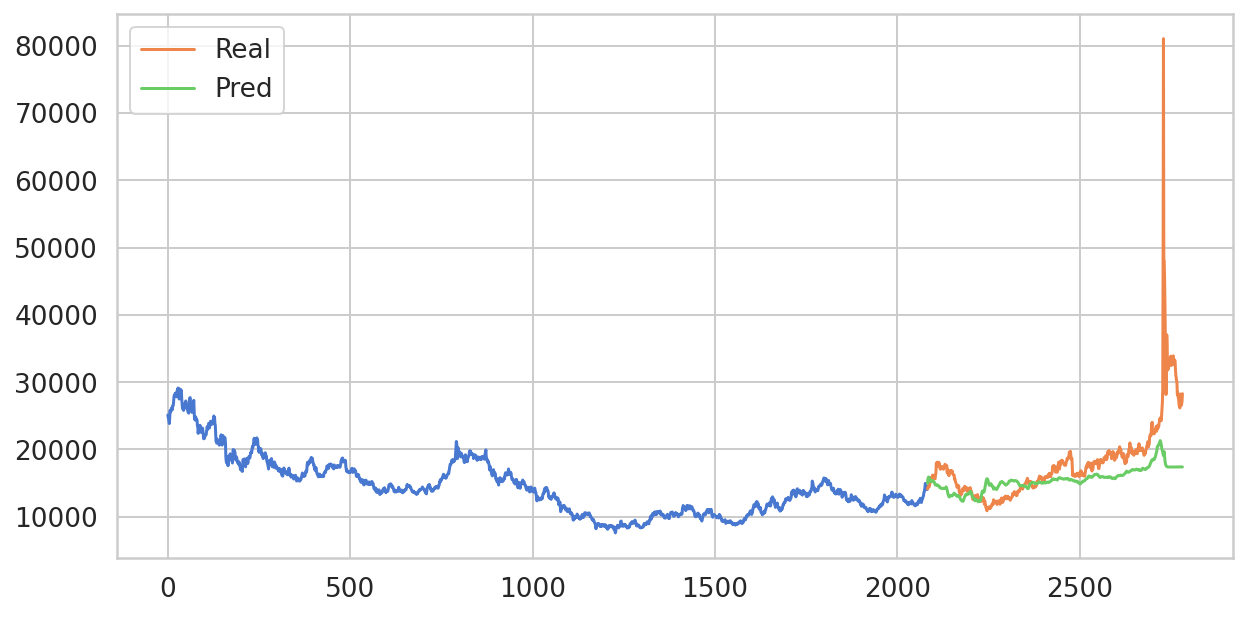

In [59]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),Yscaler.inverse_transform(np.array(y_train.cpu()).reshape(-1,1)))
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()

# 파라미터 저장

In [60]:
# 모델 저장
PATH = '/content/gdrive/MyDrive/Colab Notebooks/Elastic/weights/{0}_nickel.pth'.format(score)
torch.save(model, PATH)

In [66]:
# 모델 불러오기
model = torch.load(PATH)

In [67]:
x_cols = list(new_df.columns)
x_cols.remove("Price")

new_X = new_df[x_cols]
#Y = new_df['Price']

scaler = MinMaxScaler()
new_Xscaler = scaler.fit(new_X)
new_X_test = scaler.transform(new_X[:])

seq_length = 1

new_X_test = create_sequences(new_X_test, seq_length)
new_X_test = torch.tensor(new_X_test, device=device).float()

print(new_X_test.shape)


torch.Size([16, 1, 5])


In [75]:
new_df

,B_Price,WTI_Price,Price,Dollor_Price,EU_Price,JP_Price
Date,,,,,,
2022-07-19,105.740,98.940,20575.0,107.32,0.985,138.040
2022-07-20,106.800,100.000,20690.0,106.65,0.977,138.150
2022-07-21,106.274,99.148,21133.5,107.04,0.982,138.290
2022-07-22,104.064,96.500,21613.0,106.88,0.981,137.520
2022-07-23,103.610,95.090,22373.5,106.54,0.979,136.100
2022-07-24,103.610,95.090,22373.5,106.54,0.979,136.100
2022-07-25,98.380,95.090,22373.5,106.54,0.979,136.296
2022-07-26,101.372,97.530,22102.0,106.48,0.978,136.610
2022-07-27,99.727,95.580,21672.0,107.06,0.986,136.880


In [76]:
# Prediction value 스케일링 역변환
pred_values = Yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [77]:
pred_values

array([[14953.23286051],
       [15529.92249215],
       [15802.51583433],
       [15892.42045355],
       [15857.78191066],
       [15768.49542421],
       [15582.77380681],
       [15435.59401929],
       [15278.35850179],
       [15199.62969738],
       [15228.26086271],
       [15261.93208879],
       [15325.51503563],
       [15371.54057264],
       [15368.08018452],
       [15309.52381891],
       [15261.82361066],
       [15212.43781918],
       [15184.29255885],
       [15047.41562605],
       [14941.39205551],
       [14770.13140714],
       [14713.92497307],
       [14718.00541961],
       [14711.1635949 ],
       [14733.32779485],
       [14736.17967844],
       [14652.83124626],
       [14665.69071865],
       [14640.32288355],
       [14592.13548654],
       [14528.41325122],
       [14510.7242555 ],
       [14349.01802695],
       [14400.84425539],
       [14350.53672075],
       [14289.88846034],
       [14220.96697742],
       [14207.4072113 ],
       [14207.48487908],


In [78]:
pred_values_ceiled  = list(pred_values.flatten())

# True value 스케일링 역변환
true_values = Yscaler.inverse_transform(np.array(y_test.cpu()).reshape(-1,1))
# 실제값 예측값 데이터 프레임 생성

score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

score_table

,True,Pred
0,14137.999023,14953.232861
1,14345.000000,15529.922492
2,14307.999023,15802.515834
3,14553.000000,15892.420454
4,14473.000000,15857.781911
...,...,...
695,27731.998047,17397.361927
696,26550.000000,17395.203277
697,26788.000000,17393.158881
698,27197.998047,17391.651100


# Using all data for Training

In [79]:
# X변수들과 y변수 구분
X_all = df[x_cols]
y_all = df['Price']

KeyError: ignored

In [ ]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = scaler.fit_transform(X_all)
y_all = scaler.fit_transform(y_all.values.reshape(-1,1)).flatten()


In [ ]:
y_all

array([0.23862677, 0.23318178, 0.23064986, ..., 0.26133239, 0.26691351,
       0.28169666])

In [ ]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (2783, 18)
y_all :  (2783,)


In [ ]:
X_all = create_sequences(X_all, seq_length)
y_all = create_sequences(y_all, seq_length)

In [ ]:
X_all = torch.tensor(X_all, device=device).float()
y_all = torch.tensor(y_all, device=device).float()
#X_all = torch.from_numpy(np.array(X_all)).float()
#y_all = torch.from_numpy(np.array(y_all)).float()

In [ ]:
model.eval()
with torch.no_grad() :
  new_preds=[]
  for i in range(len(new_X_test)):
    test_seq = new_X_test[i:i+1]
    new_y_test_pred = model(test_seq)
    new_pred = torch.flatten(new_y_test_pred).item()
    new_preds.append(new_pred)
    new_seq = test_seq.cpu().numpy().flatten()
    new_seq = np.append(new_seq, pred)
    new_seq = new_seq[1:]

In [ ]:
DAYS_TO_PREDICT = len(new_X_test)
with torch.no_grad():
    #test_seq = X_all[:1]
    preds = []
    for _ in range(len(new_X_test)):
        y_test_pred = model(new_X_test[i:i+1])
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.cpu().numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
# Prediction value 스케일링 역변환
pred_values = Yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [ ]:
# 예측값 반올림
import math

pred_values_ceiled = list(pred_values.flatten())
predicted_cases=pred_values_ceiled
predicted_cases

[21225.639183282852,
 21225.635331988335,
 21225.635331988335,
 21225.632764458656,
 21225.632764458656,
 21225.632764458656,
 21225.632764458656,
 21225.632764458656,
 21225.632764458656,
 21225.632764458656,
 21225.632764458656,
 21225.632764458656,
 21225.632764458656,
 21225.632764458656,
 21225.632764458656,
 21225.632764458656]

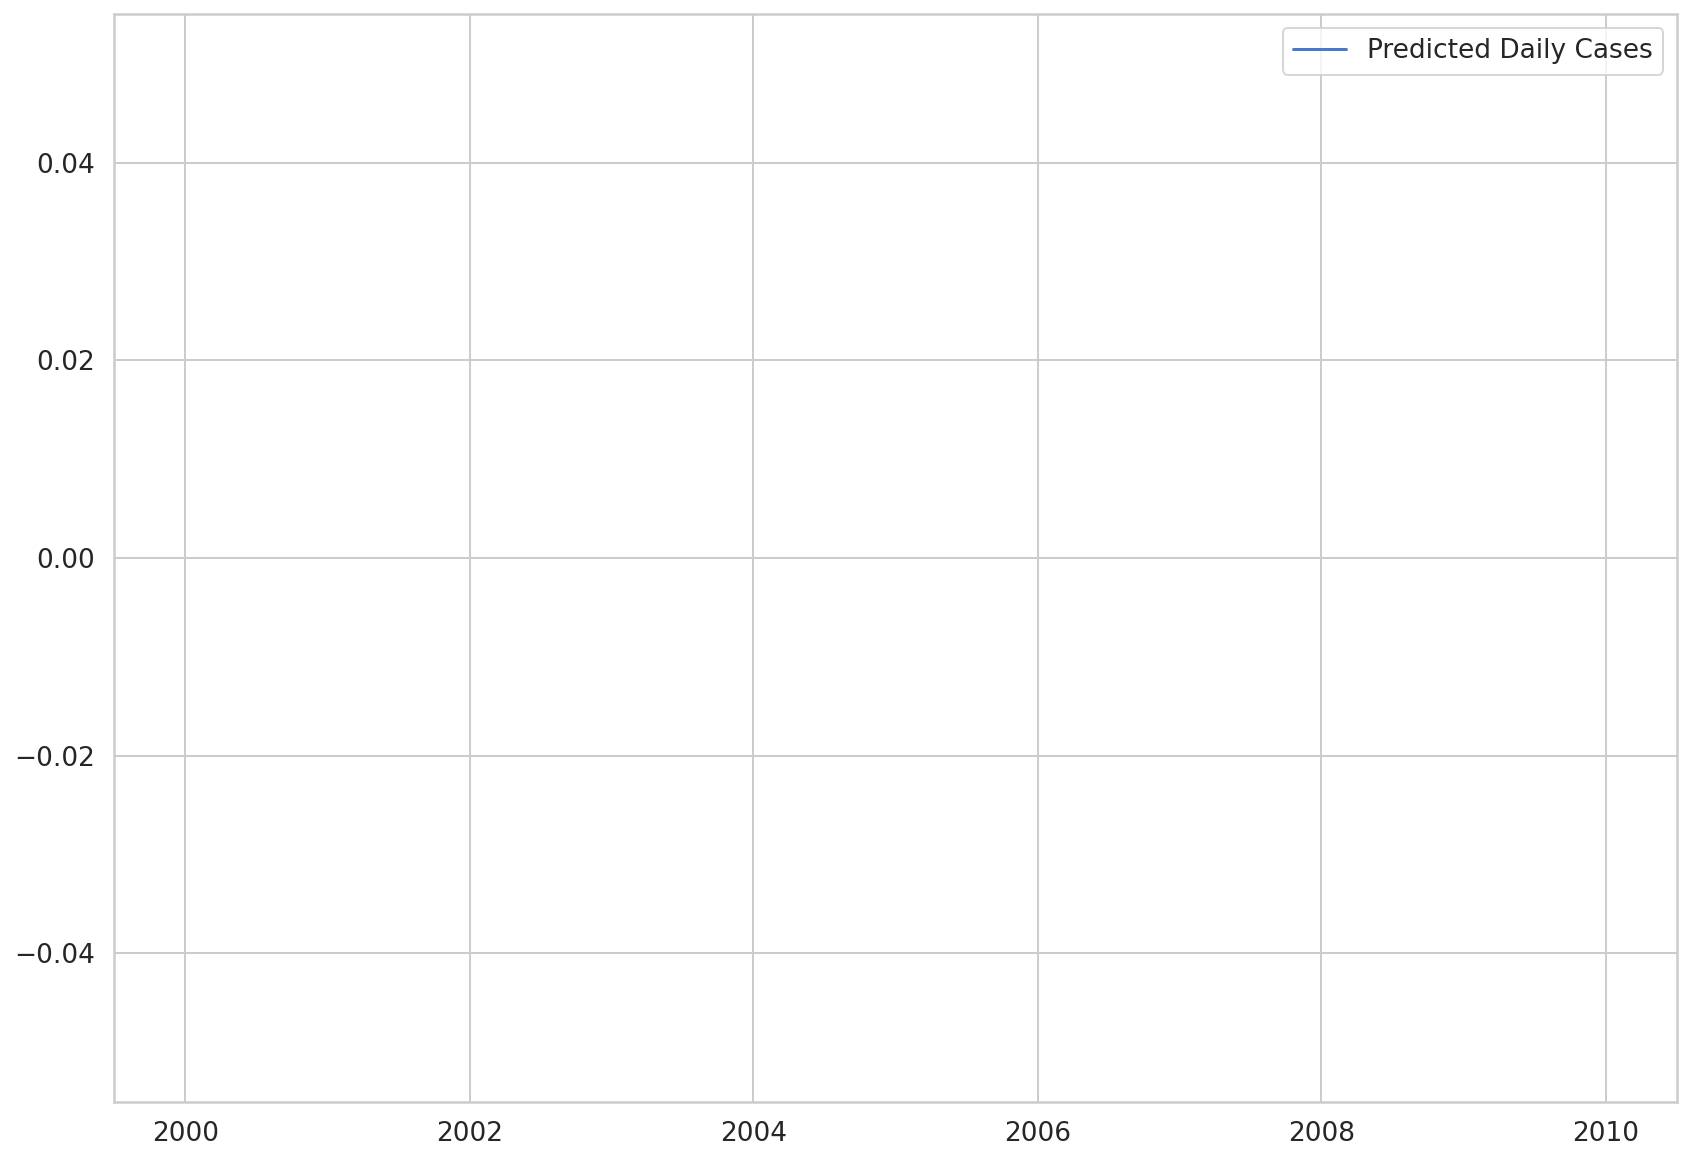

In [ ]:
predicted_index = pd.date_range(
  start=new_df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [ ]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

preds_

,0
2022-05-28,70661.260751
2022-05-29,70662.241574
2022-05-30,70663.020979
2022-05-31,70663.642751
2022-06-01,70664.150677
...,...
2022-08-31,70666.199898
2022-09-01,70666.199898
2022-09-02,70666.199898
2022-09-03,70666.199898


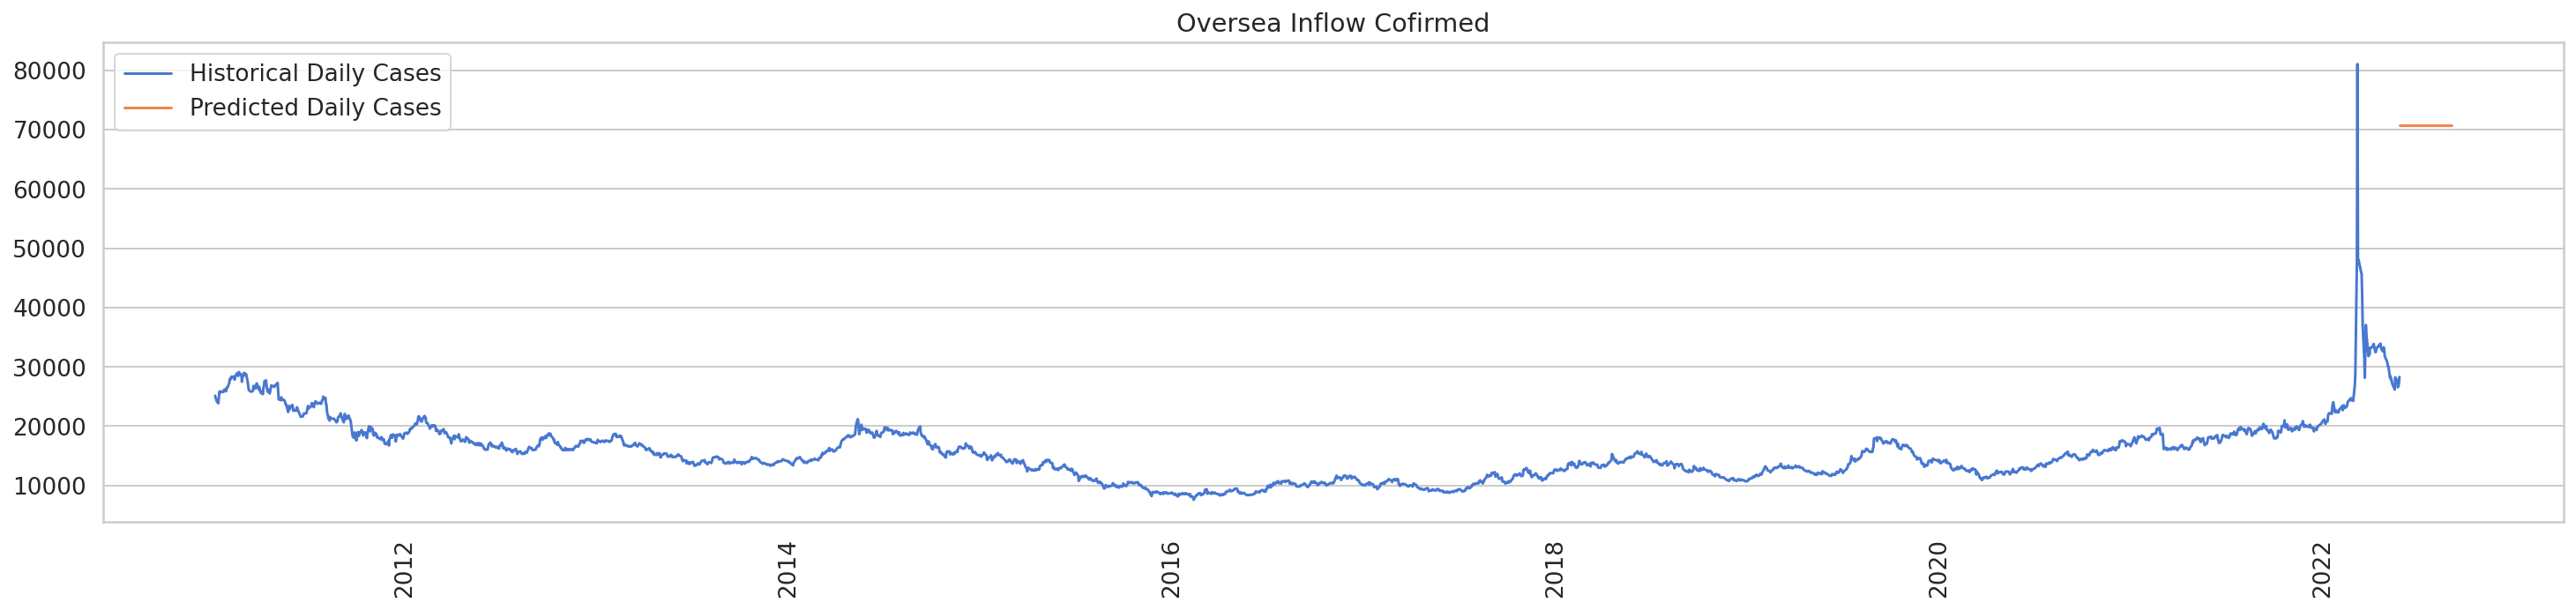

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(df['Price'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend();

# CNN-LSTM

In [ ]:
class CNN_LSTM(nn.Module) :
  def __init__(self, n_features, n_hidden, seq_len, n_layers) :
    super(CNN_LSTM, self).__init__()
    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    self.c1 = nn.Conv1d(in_channels=n_features, 
                        out_channels=100, 
                        kernel_size = 3, 
                        stride = 2
                        ) # 1D CNN 레이어 추가
    self.lstm = nn.LSTM(
        input_size = 100,
        hidden_size=n_hidden,
        num_layers=n_layers
        )
    
    self.linear = nn.Linear(in_features = n_hidden, out_features = 1)


  def reset_hidden_state(self) :
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden, device=device),
        torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden, device=device)
    )

  def forward(self, sequences) :
    sequences = self.c1(sequences.view(len(sequences), 1, -1))
    lstm_out, self.hidden = self.lstm(
        sequences.view(sequences.size(0), self.seq_len-1, -1),
        self.hidden
    )
    last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [ ]:
model = CNN_LSTM(
    n_features=X_train.shape[-1],
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
).to(device)
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    num_epochs=100,
    verbose=10,
    patience=50
)

RuntimeError: ignored